In [102]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [103]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep = ';',index_col = 'Unnamed: 0')

In [104]:
df.head()

uid  experimentVariant version  purchase
1  c4ca4238a0b923820dcc509a6f75849b                  1  v2.8.0         0
2  c81e728d9d4c2f636f067f89cc14862c                  0  v2.9.0         0
3  eccbc87e4b5ce2fe28308fd9f2a7baf3                  1  v2.9.0         0
4  a87ff679a2f3e71d9181a67b7542122c                  1  v2.8.0         0
5  e4da3b7fbbce2345d7772b0674a318d5                  1  v2.8.0         0

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127018 entries, 1 to 127018
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   uid                127018 non-null  object
 1   experimentVariant  127018 non-null  int64 
 2   version            127018 non-null  object
 3   purchase           127018 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.8+ MB


In [106]:
var1 = df.query("experimentVariant == 0")
var2 = df.query("experimentVariant == 1")

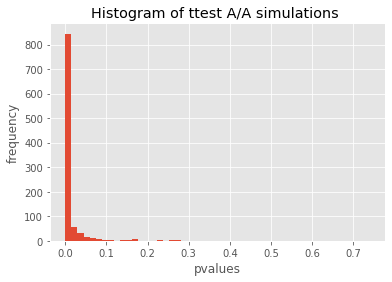

0.935

In [107]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = var1.purchase.sample(n_s, replace = False).values
    s2 = var2.purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

FPR > альфа, значит сплит система поломана. Посмотрим на конверсию в группировке по варианту эксперимента и версии мобильного приложения.

In [108]:
df.groupby(['experimentVariant', 'version']).agg({'purchase':'mean'})

purchase
experimentVariant version           
0                 v2.8.0    0.000993
                  v2.9.0    0.074658
                  v3.7.4.0  0.059943
                  v3.8.0.0  0.057604
1                 v2.8.0    0.045606
                  v2.9.0    0.071304
                  v3.7.4.0  0.063018
                  v3.8.0.0  0.062848

Видим, что в одной из групп версии приложения v2.8.0 конверсия в разы меньше, чем в другой. Посчитаем pvalue для каждой версии МП.

In [109]:
stats.mannwhitneyu(var1.query('version=="v2.8.0"').purchase,var2.query('version=="v2.8.0"').purchase)

MannwhitneyuResult(statistic=819431781.5, pvalue=0.0)

In [110]:
stats.mannwhitneyu(var1.query('version=="v2.9.0"').purchase,var2.query('version=="v2.9.0"').purchase)

MannwhitneyuResult(statistic=71482120.5, pvalue=0.15914991735354062)

In [111]:
stats.mannwhitneyu(var1.query('version=="v3.7.4.0"').purchase,var2.query('version=="v3.7.4.0"').purchase)

MannwhitneyuResult(statistic=8845256.0, pvalue=0.27843241241087335)

In [112]:
stats.mannwhitneyu(var1.query('version=="v3.8.0.0"').purchase,var2.query('version=="v3.8.0.0"').purchase)

MannwhitneyuResult(statistic=17303962.0, pvalue=0.11592818319478931)

Замечаем, что pvalue < 0.05 для версии v2.8.0 , исключим ее из основного датафрейма и проведем тест еще раз.

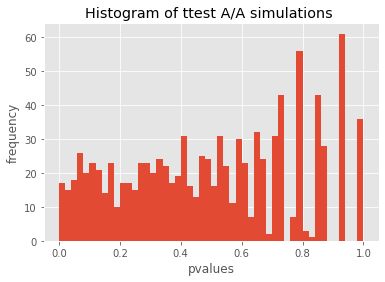

0.044

In [113]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = var1.query('version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = var2.query('version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Теперь FPR < альфа. Поломка найдена.